# Purpose

Some quick and dirty analysis to see if BRAF (outlined in https://ieeexplore.ieee.org/document/8541100) provides a performance boost over the open source PIMA Indian Diabetes Dataset (won't share it here but you can probably find it yourself).

# Imports

In [5]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# Set random seed to ensure reproducible runs
RSEED = 50

# Functions

In [3]:
def series_percent_val(ser: pd.Series, 
                       val: int = 0):
    '''
    calculates the percent frequency that val is observed in the series 

    Parameters
    ----------
    ser: pandas.Series
    val: int (default=0)
    
    Returns
    -------
    pct: float
    
    '''
    
    val_counts = ser.value_counts(normalize=True)
    try:
        pct = val_counts[val]
    except:
        pct = 0
    
    return pct

def df_pct_zeros(df: pd.DataFrame):
    '''
    returns percent of values of df that are 0 in each column

    Parameters
    ----------
    df: pandas.DataFrame
    
    Returns
    -------
    df: pandas.DataFrame
    
    '''
    zero_pct = {}
    for col in df.columns:
        pct = series_percent_val(df[col])
        zero_pct[col] = pct

    df_pct_zeros = pd.DataFrame.from_dict(zero_pct, orient='index', columns=['pct_0'])
    
    return df_pct_zeros.sort_values('pct_0', ascending=False)

def impute_with_mean(ser: pd.Series, 
                     missing_val: int = 0):
    '''
    imputes missing values in a series with the constant mean of the non-missing values 

    Parameters
    ----------
    ser: pandas.Series
    missing_val: int (default=0)
    
    Returns
    -------
    out: pandas.Series
        Same series as input, but with all missing values replaced with the mean

    '''
    dtype = ser.dtype
    mean = ser[ser != missing_val].mean()
    ser = ser.where(ser != missing_val, other=mean)
    
    return out

def impute_with_fittednormal(ser: pd.Series, 
                             missing_val: int = 0):
    '''
    imputes missing values in a series by drawing from a normal curve that fits the 
    non-missing values 

    Parameters
    ----------
    ser: pandas.Series
    missing_val: int (default=0)
    
    Returns
    -------
    out: pandas.Series
        Same series as input, but with all missing values replaced with draws from the
        fitted normal distribution
    '''
    dtype = ser.dtype
    mu, std = norm.fit(ser[ser != missing_val])
    for i,val in enumerate(ser):
        if val == missing_val:
            ser[i] = np.clip(np.random.normal(mu, std, 1), 0, None) # 1 draw, clipped only at a lower bound of 0
    out = ser.astype(dtype)
    
    return out


In [6]:
# We only need this half import to make this run locally in our notebook. If we 
# were to actually submit this to sklearn, it would make sense to make this an 
# import of ForestClassifier here directly. 
from sklearn.ensemble.forest import _forest

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier

class BiasedRandomForestClassifier(_forest.ForestClassifier):
    """
    NOTE this documentation steals from the RandomForestClassifier documentation, where possible. :) 
    
    Known limitations (And there's definitely more that I haven't tested): 
        - Only works with single-target prediction
        
    A forest-based classifier in which two separate `RandomForestClassifier`s are grown. 
    They differ in how records are sampled:
    1) sampling the full dataset
    2) subsampling the minority class and its majority class `n_neighbors`. 
    
    The number of trees in each forest is given by the `forest_ratio` parameter. The predictions
    are a result of statistics applied to all estimator trees between both classifiers
    
    See RandomForestClassifier for more information on how the underlying random forest machinery 
    functions. Read more in the :ref:`User Guide <forest>`.
    
    Parameters
    ----------
    n_estimators : integer, optional (default=100)
        The number of trees in the forest.
        .. versionchanged:: 0.22
           The default value of ``n_estimators`` changed from 10 to 100
           in 0.22.
    forest_ratio: float optional (default=0.5), 
    n_neighbors: int optional (default=10),
    criterion : string, optional (default="gini")
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "entropy" for the information gain.
        Note: this parameter is tree-specific.
    max_depth : integer or None, optional (default=None)
        The maximum depth of the tree. If None, then nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.
    min_samples_split : int, float, optional (default=2)
        The minimum number of samples required to split an internal node:
        - If int, then consider `min_samples_split` as the minimum number.
        - If float, then `min_samples_split` is a fraction and
          `ceil(min_samples_split * n_samples)` are the minimum
          number of samples for each split.
        .. versionchanged:: 0.18
           Added float values for fractions.
    min_samples_leaf : int, float, optional (default=1)
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.
        - If int, then consider `min_samples_leaf` as the minimum number.
        - If float, then `min_samples_leaf` is a fraction and
          `ceil(min_samples_leaf * n_samples)` are the minimum
          number of samples for each node.
        .. versionchanged:: 0.18
           Added float values for fractions.
    min_weight_fraction_leaf : float, optional (default=0.)
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.
    max_features : int, float, string or None, optional (default="auto")
        The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.
        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.
    max_leaf_nodes : int or None, optional (default=None)
        Grow trees with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        If None then unlimited number of leaf nodes.
    min_impurity_decrease : float, optional (default=0.)
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
        The weighted impurity decrease equation is the following::
            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.
        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.
        .. versionadded:: 0.19
    min_impurity_split : float, (default=1e-7)
        Threshold for early stopping in tree growth. A node will split
        if its impurity is above the threshold, otherwise it is a leaf.
        .. deprecated:: 0.19
           ``min_impurity_split`` has been deprecated in favor of
           ``min_impurity_decrease`` in 0.19. The default value of
           ``min_impurity_split`` will change from 1e-7 to 0 in 0.23 and it
           will be removed in 0.25. Use ``min_impurity_decrease`` instead.
    bootstrap : boolean, optional (default=True)
        Whether bootstrap samples are used when building trees. If False, the
        whole datset is used to build each tree.
    oob_score : bool (default=False)
        Whether to use out-of-bag samples to estimate
        the generalization accuracy.
    n_jobs : int or None, optional (default=None)
        The number of jobs to run in parallel. :meth:`fit`, :meth:`predict`,
        :meth:`decision_path` and :meth:`apply` are all parallelized over the
        trees. ``None`` means 1 unless in a :obj:`joblib.parallel_backend`
        context. ``-1`` means using all processors. See :term:`Glossary
        <n_jobs>` for more details.
    random_state : int, RandomState instance or None, optional (default=None)
        Controls both the randomness of the bootstrapping of the samples used
        when building trees (if ``bootstrap=True``) and the sampling of the
        features to consider when looking for the best split at each node
        (if ``max_features < n_features``).
        See :term:`Glossary <random_state>` for details.
    verbose : int, optional (default=0)
        Controls the verbosity when fitting and predicting.
    warm_start : bool, optional (default=False)
        When set to ``True``, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just fit a whole
        new forest. See :term:`the Glossary <warm_start>`.
    class_weight : dict, list of dicts, "balanced", "balanced_subsample" or
    None, optional (default=None)
        Weights associated with classes in the form ``{class_label: weight}``.
        If not given, all classes are supposed to have weight one. For
        multi-output problems, a list of dicts can be provided in the same
        order as the columns of y.
        Note that for multioutput (including multilabel) weights should be
        defined for each class of every column in its own dict. For example,
        for four-class multilabel classification weights should be
        [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of
        [{1:1}, {2:5}, {3:1}, {4:1}].
        The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``
        The "balanced_subsample" mode is the same as "balanced" except that
        weights are computed based on the bootstrap sample for every tree
        grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed
        through the fit method) if sample_weight is specified.
    ccp_alpha : non-negative float, optional (default=0.0)
        Complexity parameter used for Minimal Cost-Complexity Pruning. The
        subtree with the largest cost complexity that is smaller than
        ``ccp_alpha`` will be chosen. By default, no pruning is performed. See
        :ref:`minimal_cost_complexity_pruning` for details.
        .. versionadded:: 0.22
    max_samples : int or float, default=None
        If bootstrap is True, the number of samples to draw from X
        to train each base estimator.
        - If None (default), then draw `X.shape[0]` samples.
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples. Thus,
          `max_samples` should be in the interval `(0, 1)`.
        .. versionadded:: 0.22
        
    Attributes
    ----------
    base_estimator_ : DecisionTreeClassifier
        The child estimator template used to create the collection of fitted
        sub-estimators.
    estimators_ : list of DecisionTreeClassifier
        The collection of fitted sub-estimators.
    classes_ : array of shape (n_classes,) or a list of such arrays
        The classes labels (single output problem), or a list of arrays of
        class labels (multi-output problem).
    n_classes_ : int or list
        The number of classes (single output problem), or a list containing the
        number of classes for each output (multi-output problem).
    n_features_ : int
        The number of features when ``fit`` is performed.
    n_outputs_ : int
        The number of outputs when ``fit`` is performed.
    feature_importances_ : ndarray of shape (n_features,)
        The feature importances (the higher, the more important the feature).
    oob_score_ : float
        Score of the training dataset obtained using an out-of-bag estimate.
        This attribute exists only when ``oob_score`` is True.
    oob_decision_function_ : array of shape (n_samples, n_classes)
        Decision function computed with out-of-bag estimate on the training
        set. If n_estimators is small it might be possible that a data point
        was never left out during the bootstrap. In this case,
        `oob_decision_function_` might contain NaN. This attribute exists
        only when ``oob_score`` is True.
    
    Examples
    --------
    >>> from sklearn.ensemble import BiasedRandomForestClassifier
    >>> from sklearn.datasets import make_classification
    >>> X, y = make_classification(n_samples=1000, n_features=4,
    ...                            n_informative=2, n_redundant=0,
    ...                            random_state=0, shuffle=False)
    >>> clf = BiasedRandomForestClassifier(max_depth=2, random_state=0)
    >>> clf.fit(X, y)
    BiasedRandomForestClassifier(max_depth=2, random_state=0)
    >>> print(clf.feature_importances_)
    [0.14205973 0.76664038 0.0282433  0.06305659]
    >>> print(clf.predict([[0, 0, 0, 0]]))
    [1]
    
    Notes
    -----
    The default values for the parameters controlling the size of the trees
    (e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
    unpruned trees which can potentially be very large on some data sets. To
    reduce memory consumption, the complexity and size of the trees should be
    controlled by setting those parameter values.
    The features are always randomly permuted at each split. Therefore,
    the best found split may vary, even with the same training data,
    ``max_features=n_features`` and ``bootstrap=False``, if the improvement
    of the criterion is identical for several splits enumerated during the
    search of the best split. To obtain a deterministic behaviour during
    fitting, ``random_state`` has to be fixed.
    
    References
    ----------
    .. [1] L. Breiman, "Random Forests", Machine Learning, 45(1), 5-32, 2001.
    
    See Also
    --------
    RandomForestClassifier
    
    """

    def __init__(self, 
                 n_estimators: int = 100, 
                 forest_ratio: float = 0.5, 
                 n_neighbors: int = 10,
                 bootstrap: bool = False,
                 oob_score: bool = False,
                 n_jobs: int = None,
                 random_state: int = None,
                 verbose: int = 0,
                 warm_start: bool = False,
                 class_weight: dict = None,
                 max_samples: int = None,
                 **params):
        
        self.n_estimators=n_estimators
        self.forest_ratio = forest_ratio
        self.n_neighbors = n_neighbors

        self.n_fulldata_estimators = round(n_estimators*forest_ratio)
        self.n_undersampled_estimators = n_estimators - self.n_fulldata_estimators
        self.RF1 = RandomForestClassifier(n_estimators=self.n_fulldata_estimators, **params)
        self.RF2 = RandomForestClassifier(n_estimators=self.n_undersampled_estimators, **params)
        self.NN = NearestNeighbors(n_neighbors=n_neighbors)
        
        # gives access to the suite of functions built into all sklearn ForestClassifiers
        super().__init__(
            base_estimator=DecisionTreeClassifier(),
            n_estimators=n_estimators,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            max_samples=max_samples
        )
        
    def _undersample(self, X, y):
        """
        Resample the data to use in the minority-biased forest.
        
        Parameters
        ----------
        X : array-like or sparse matrix of shape (n_samples, n_features)
            The training input samples. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        
        Returns
        -------
        X_undersampled : array-like or sparse matrix of shape (n_underesamples, n_features)
            The training input to the undersampled forest. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.
        y_undersampled : array-like of shape (n_underesamples,) or (n_underesamples, n_outputs)
            The target values to the undersampled forest. (class labels in classification, real numbers in
            regression).
        """
        
        # split data into majority and minority classes
        _, cts = np.unique(y)
        minority_val = cts.min()
        X_minority = X[y==minority_val]
        X_majority = X[y!=minority_val]
        y_minority = np.expand_dims(y[y==minority_val], axis=1)
        y_majority = np.expand_dims(y[y!=minority_val], axis=1)
        
        # get set of majority data that are nearest neighbors to the minority data
        self.NN = self.NN.fit(X_majority)
        neighbors = list(set(self.NN.kneighbors(X_minority, return_distance=False).reshape(-1)))
        
        # combine moinority set with majority neighboors
        X_undersampled = np.vstack([X_majority[neighbors], X_minority])
        y_undersampled = np.vstack([y_majority[neighbors], y_minority])

        return X_undersampled, y_undersampled
         
    def fit(self, X, y):
        """
        Build a forest of trees from the training set (X, y).
        
        Parameters
        ----------
        X : array-like or sparse matrix of shape (n_samples, n_features)
            The training input samples. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        
        Returns
        -------
        self : object
        """

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(unique_labels(y))
        
        # store the n_outputs seen during fit
        if len(y.shape) == 1:
            self.n_outputs_ = 1
        else:
            self.n_outputs_ = y.shape[1]
        
        # undersample the data based on BRAF methodology
        X_undersampled, y_undersampled = self._undersample(X, y) 
        
        # fit both random forests 
        self.RF1 = self.RF1.fit(X, y)
        self.RF2 = self.RF2.fit(X_undersampled, y_undersampled)
        
        # collect estimators (trees) from both forests
        trees = []
        for tree in range(self.n_fulldata_estimators):
            trees.append(self.RF1.estimators_[tree])
        for tree in range(self.n_undersampled_estimators):
            trees.append(self.RF2.estimators_[tree])
        self.estimators_ = trees
        
        # Return the classifier object
        return self


# Data Prep

In [7]:
df_raw = pd.read_csv('diabetes.csv')
print(len(df_raw))

768


In [8]:
df_raw.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [9]:
df_raw.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Looks like we have a null data problem! :(

In [10]:
df_pct_zeros(df_raw)

,pct_0
Outcome,0.651042
Insulin,0.486979
SkinThickness,0.295573
Pregnancies,0.144531
BloodPressure,0.045573
BMI,0.014323
Glucose,0.006510
DiabetesPedigreeFunction,0.000000
Age,0.000000


Probably not the best idea to impute with a normal distribution that's fitted to each 1d column for mainly 3 reasons: 
   - we're ignoring correlations between columns.
   - we're ignoring joint distributions. 
   - are we sure normals are good fits? Could a different distribution be the more appropriate fit?
 
It would probably be smarter to fit a multivariate normal to this so we can get that sweet covariance matrix, but at that point we're basically fitting a model... so that we can fit another model later. Would be interesting to see how the model results changed if we had more time. 

In [11]:
# df_filtered = df_raw.copy()
df_filtered_norm = df_raw.copy()
for col in ['Insulin', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'BMI', 'Glucose']:
#     df_filtered[col] = impute_with_mean(df_raw[col])
    df_filtered_norm[col] = impute_with_fittednormal(df_raw[col])
    

In [12]:
df_filtered_norm.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.496094,121.746094,72.319010,29.161458,153.959635,32.501199,0.471876,33.240885,0.348958
std,3.191005,30.513200,12.269828,10.368188,113.966530,6.945140,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,16.724915,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,22.000000,74.000000,27.500000,0.243750,24.000000,0.000000
50%,4.000000,117.000000,72.000000,29.000000,130.000000,32.350000,0.372500,29.000000,0.000000
75%,7.000000,141.000000,80.000000,36.000000,208.250000,36.800000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


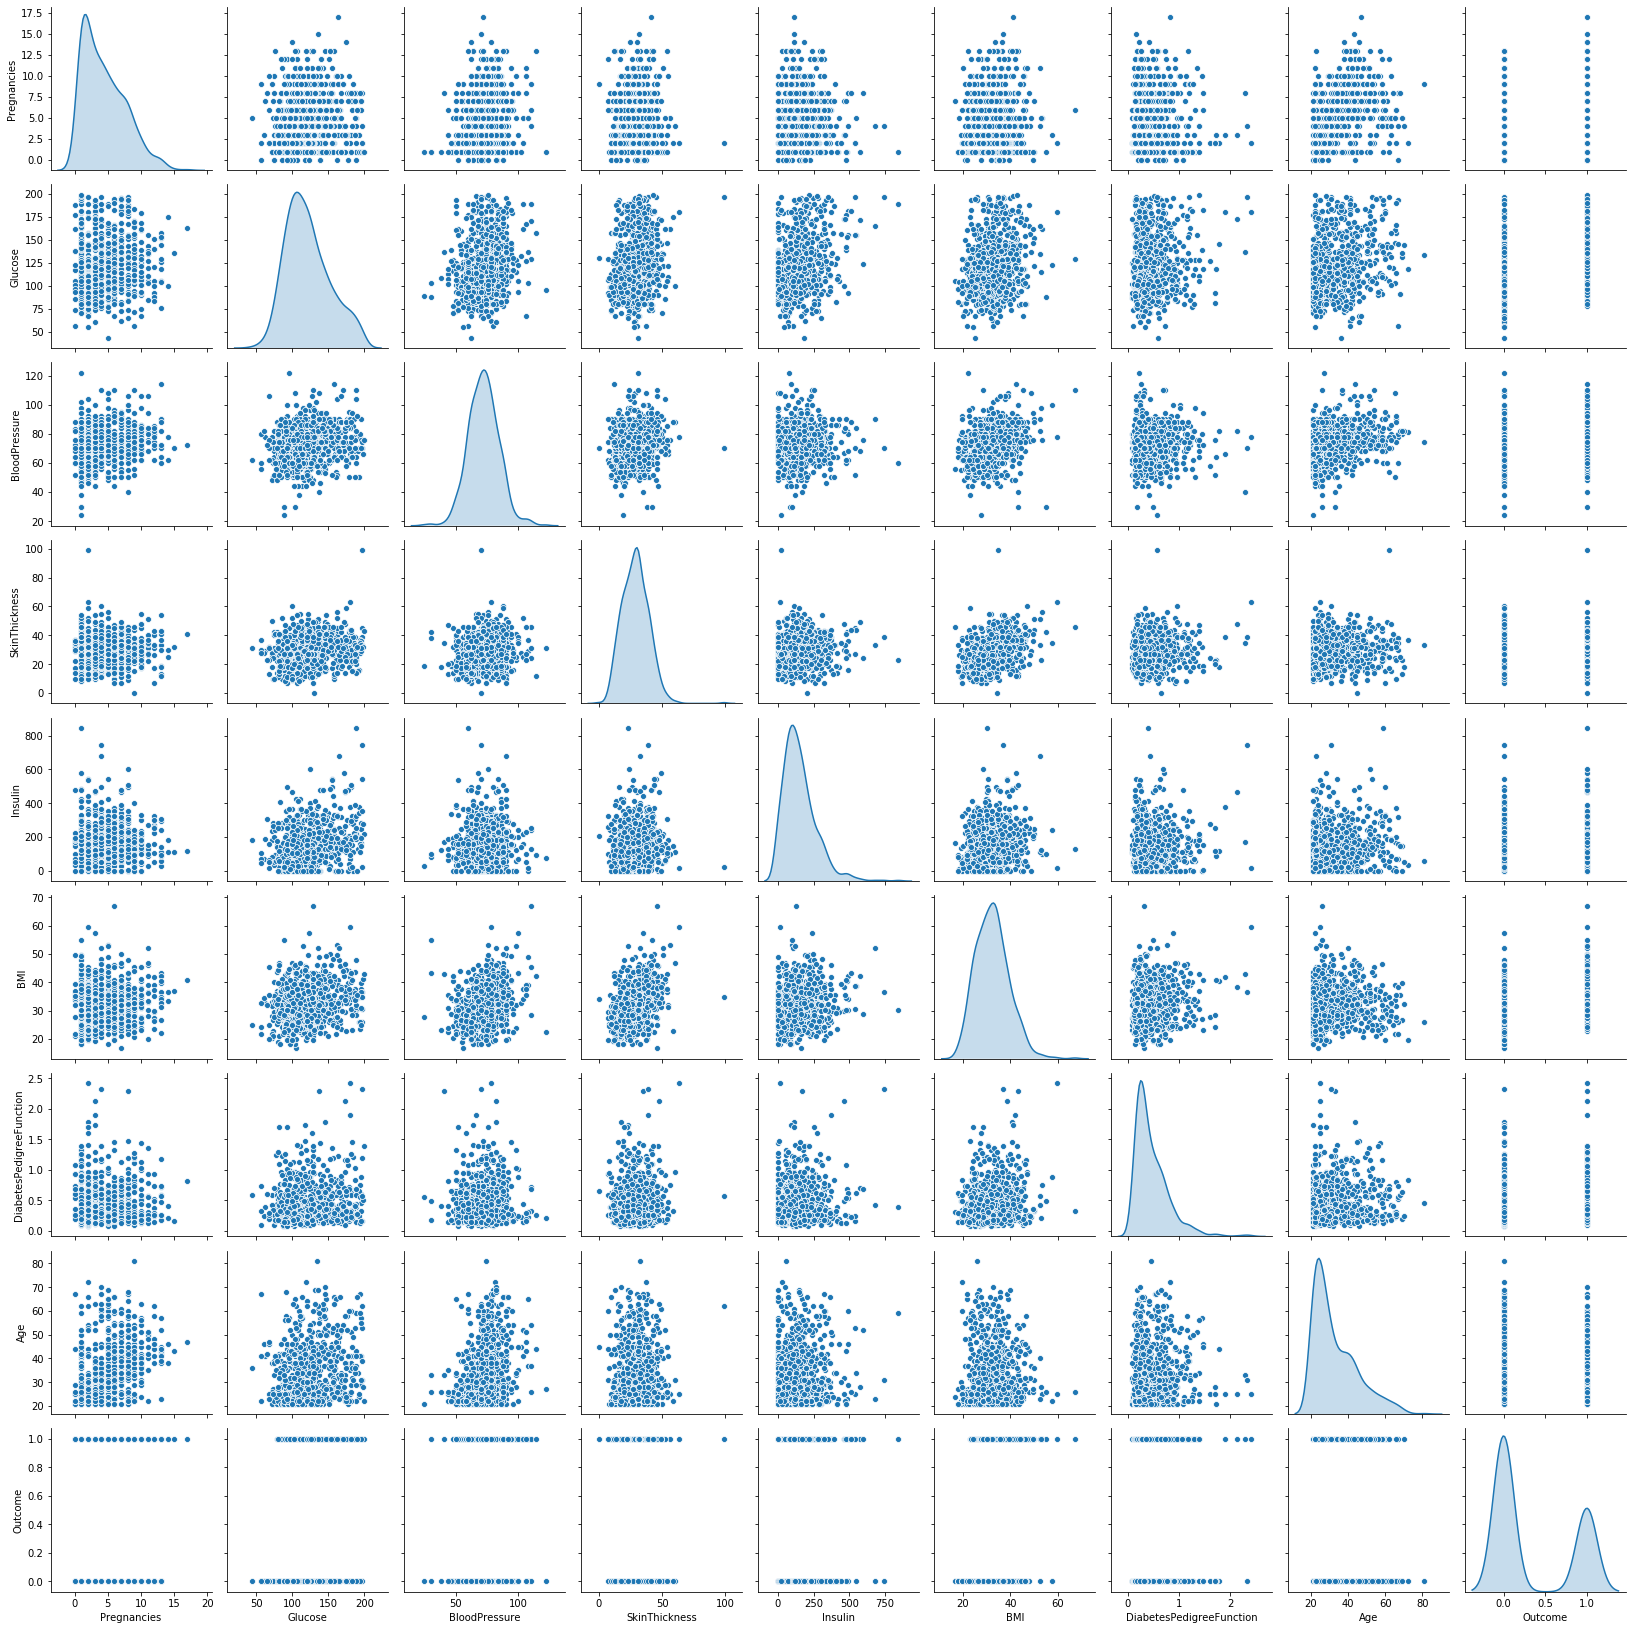

In [13]:
sns.pairplot(df_filtered_norm, diag_kind='kde')

Correlations!

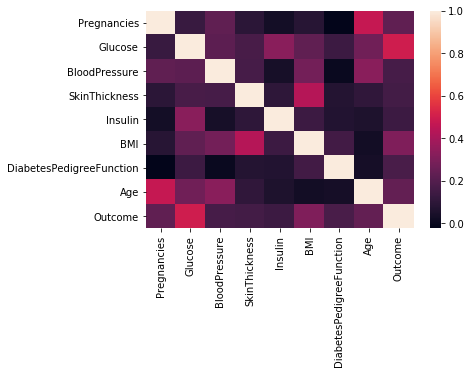

In [16]:
sns.heatmap(df_filtered_norm.corr())

decided not to go with a column expressing BMI/thickness just yet but would love to try that next. We should consider exploring it since there's both a mathematical correlation and an intuitive one. 

In [17]:
# df_filtered['BMI_over_thick'] = df_filtered['BMI']/df_filtered['SkinThickness']
# sns.distplot(df_filtered['BMI_over_thick'].dropna())

# Train

In [18]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = df_filtered_norm.pop('Outcome')
X = df_filtered_norm.to_numpy()

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(X, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)


## Cross Validate

In [19]:
braf = BiasedRandomForestClassifier(n_jobs=2)
rf = RandomForestClassifier(n_jobs=2)

from sklearn.model_selection import cross_validate

cv_braf = pd.DataFrame(cross_validate(braf, 
                                      X, 
                                      labels, 
                                      scoring=['roc_auc', 'precision', 'recall', 'average_precision'], 
                                      cv=10,
#                                       return_train_score=True
                                     ))
cv_rf = pd.DataFrame(cross_validate(rf, 
                                    X, 
                                    labels, 
                                    scoring=['roc_auc', 'precision', 'recall', 'average_precision'], 
                                    cv=10,
#                                     return_train_score=True
                                   ))


In [20]:
cv_rf.describe(percentiles=[])

,fit_time,score_time,test_roc_auc,test_precision,test_recall,test_average_precision
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.143751,0.015371,0.829766,0.662270,0.556125,0.715257
std,0.001150,0.000199,0.061636,0.106998,0.080285,0.105374
min,0.142048,0.014957,0.705185,0.520000,0.407407,0.545317
50%,0.143551,0.015428,0.854074,0.660909,0.574074,0.736294
max,0.145960,0.015613,0.897407,0.823529,0.666667,0.833485


In [21]:
cv_braf.describe(percentiles=[])

,fit_time,score_time,test_roc_auc,test_precision,test_recall,test_average_precision
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.150280,0.015489,0.825591,0.673558,0.570940,0.713089
std,0.009767,0.000527,0.054331,0.111716,0.105735,0.085730
min,0.144117,0.014994,0.711852,0.516129,0.407407,0.565759
50%,0.145951,0.015332,0.838704,0.690476,0.574074,0.723556
max,0.175352,0.016717,0.889630,0.791667,0.703704,0.804882


## Train/Test

roc_auc: 	 0.8389711934156379
ave_precision: 	 0.7051007428022358
precision: 	 0.7058823529411765
recall: 	 0.5925925925925926


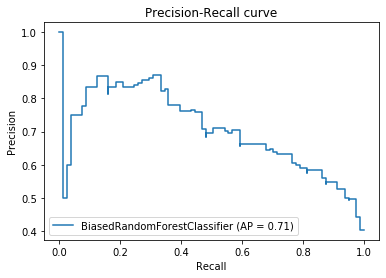

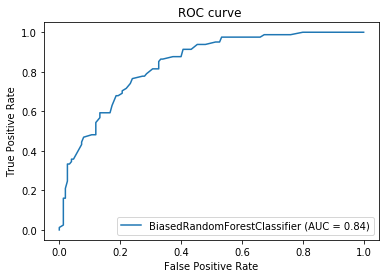

In [22]:
from sklearn.metrics import (
            plot_precision_recall_curve, 
            plot_roc_curve, 
            roc_auc_score, 
            average_precision_score, 
            precision_score, 
            recall_score,
)
import matplotlib.pyplot as plt


# train
braf = BiasedRandomForestClassifier(n_jobs=2)
braf.fit(train, train_labels)

# predict
predictions = braf.predict(test)
prediction_probs = braf.predict_proba(test)

# metrics
roc_auc = roc_auc_score(test_labels, prediction_probs[:,1])
ap = average_precision_score(test_labels, prediction_probs[:,1])
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
print('roc_auc: \t', roc_auc)
print('ave_precision: \t', ap)
print('precision: \t', precision)
print('recall: \t', recall)

# plots
prc = plot_precision_recall_curve(braf, test, test_labels)
prc.ax_.set_title('Precision-Recall curve');
plt.savefig('braf_PRC.png')
roc = plot_roc_curve(braf, test, test_labels)
roc.ax_.set_title('ROC curve ');
plt.savefig('braf_AUC.png')